# A simple 2D Flow Matching model

This notebook trains and evaluates a simple 2D FM model with CondOT (i.e., linear) scheduler.

Dataset: 2D checkerboard
Model (velocity): MLP

## Imports and init device

In [24]:
import time
import torch

from torch import nn, Tensor

# flow_matching
from flow_matching.path.scheduler import CondOTScheduler
from flow_matching.path import AffineProbPath
from flow_matching.solver import Solver, ODESolver
from flow_matching.utils import ModelWrapper

# visualization
import matplotlib.pyplot as plt

from matplotlib import cm

from peft import LoraConfig, get_peft_model


# To avoide meshgrid warning
import warnings

warnings.filterwarnings("ignore", category=UserWarning, module='torch')

In [25]:
if torch.cuda.is_available():
    device = 'cuda:0'
    print('Using gpu')
else:
    device = 'cpu'
    print('Using cpu.')

Using gpu


In [26]:
torch.manual_seed(42)

## Dataset

In [27]:
def inf_train_gen(batch_size: int = 200, device: str = "cpu"):
    x1 = torch.rand(batch_size, device=device) * 4 - 2
    x2_ = torch.rand(batch_size, device=device) - torch.randint(high=2, size=(batch_size, ), device=device) * 2
    x2 = x2_ + (torch.floor(x1) % 2)

    data = 1.0 * torch.cat([x1[:, None], x2[:, None]], dim=1) / 0.45
    
    return data.float()

## Model

In [28]:
# Activation class
class Swish(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x: Tensor) -> Tensor: 
        return torch.sigmoid(x) * x

# Model class
class MLP(nn.Module):
    def __init__(self, input_dim: int = 2, time_dim: int = 1, hidden_dim: int = 128):
        super().__init__()
        
        self.input_dim = input_dim
        self.time_dim = time_dim
        self.hidden_dim = hidden_dim

        self.main = nn.Sequential(
            nn.Linear(input_dim+time_dim, hidden_dim),
            Swish(),
            nn.Linear(hidden_dim, hidden_dim),
            Swish(),
            nn.Linear(hidden_dim, hidden_dim),
            Swish(),
            nn.Linear(hidden_dim, hidden_dim),
            Swish(),
            nn.Linear(hidden_dim, input_dim),
            )
    

    def forward(self, x: Tensor, t: Tensor) -> Tensor:
        sz = x.size()
        x = x.reshape(-1, self.input_dim)
        t = t.reshape(-1, self.time_dim).float()

        t = t.reshape(-1, 1).expand(x.shape[0], 1)
        h = torch.cat([x, t], dim=1)
        output = self.main(h)
        
        return output.reshape(*sz)

## Train Velocity Flow Matching model

In [ ]:
# training arguments
lr = 0.001
batch_size = 4096
iterations = 20001
print_every = 2000 
hidden_dim = 512

# velocity field model init
vf = MLP(input_dim=2, time_dim=1, hidden_dim=hidden_dim).to(device) 

original_vf = MLP(input_dim=2, time_dim=1, hidden_dim=hidden_dim).to(device)   # keep a copy of the original model for visualization

# instantiate an affine path object
path = AffineProbPath(scheduler=CondOTScheduler())



lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=["main.0", "main.2", "main.4", "main.6"],  # target Linear layers in MLP
    init_lora_weights="gaussian",
)
vf = get_peft_model(vf, lora_config)
# init optimizer (only optimize LoRA parameters)
optim = torch.optim.Adam(vf.parameters(), lr=lr)
optim.param_groups[0]['params'] = [p for n, p in vf.named_parameters() if 'lora_' in n]

# train
start_time = time.time()

for i in range(iterations):
    optim.zero_grad() 

    # sample data (user's responsibility): in this case, (X_0,X_1) ~ pi(X_0,X_1) = N(X_0|0,I)q(X_1)
    x_1 = inf_train_gen(batch_size=batch_size, device=device) # sample data
    x_0 = torch.randn_like(x_1).to(device)

    # sample time (user's responsibility)
    t = torch.rand(x_1.shape[0]).to(device) 

    # sample probability path
    path_sample = path.sample(t=t, x_0=x_0, x_1=x_1)

    # flow matching l2 loss
    loss = torch.pow( vf(path_sample.x_t,path_sample.t) - path_sample.dx_t, 2).mean() 

    # optimizer step
    loss.backward() # backward
    optim.step() # update
    
    # log loss
    if (i+1) % print_every == 0:
        elapsed = time.time() - start_time
        print('| iter {:6d} | {:5.2f} ms/step | loss {:8.3f} ' 
              .format(i+1, elapsed*1000/print_every, loss.item())) 
        start_time = time.time()
        vf.save_pretrained(f"lora_weights_step_{i+1}")

| iter   2000 |  2.65 ms/step | loss    3.824 
| iter   4000 |  2.66 ms/step | loss    3.687 
| iter   6000 |  2.63 ms/step | loss    3.808 
| iter   8000 |  2.62 ms/step | loss    3.706 
| iter  10000 |  2.76 ms/step | loss    3.693 
| iter  12000 |  7.43 ms/step | loss    3.642 
| iter  14000 |  8.03 ms/step | loss    3.731 
| iter  16000 |  8.04 ms/step | loss    3.712 
| iter  18000 |  7.23 ms/step | loss    3.709 
| iter  20000 |  6.86 ms/step | loss    3.880 


#### Sample from trained model

In [17]:
class WrappedModel(ModelWrapper):
    def forward(self, x: torch.Tensor, t: torch.Tensor, **extras):
        return self.model(x, t)

wrapped_vf = WrappedModel(original_vf)

In [18]:
# step size for ode solver
step_size = 0.05

norm = cm.colors.Normalize(vmax=50, vmin=0)

batch_size = 50000  # batch size
eps_time = 1e-2
T = torch.linspace(0,1,10)  # sample times
T = T.to(device=device)

x_init = torch.randn((batch_size, 2), dtype=torch.float32, device=device)
solver = ODESolver(velocity_model=wrapped_vf)  # create an ODESolver class
sol = solver.sample(time_grid=T, x_init=x_init, method='midpoint', step_size=step_size, return_intermediates=True)  # sample from the model

### Visualize the path

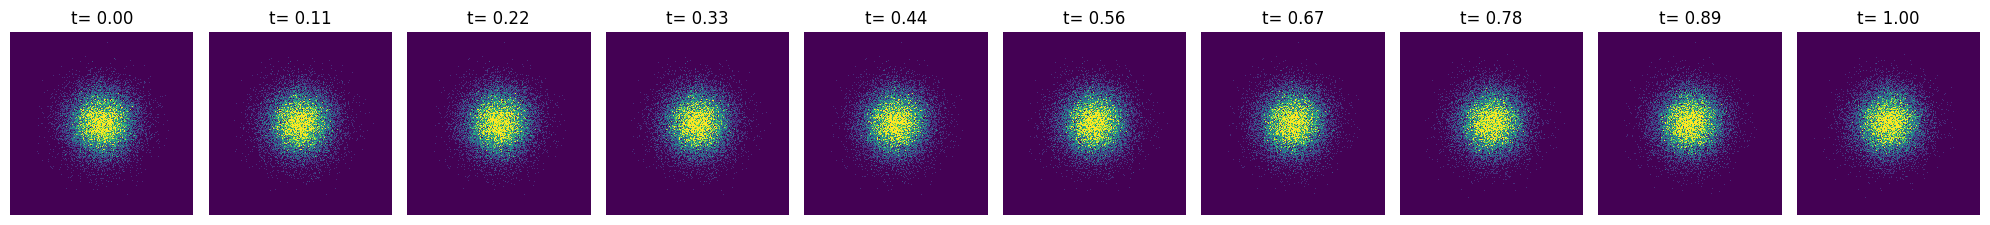

In [19]:
sol = sol.cpu().numpy()
T = T.cpu()

fig, axs = plt.subplots(1, 10,figsize=(20,20))

for i in range(10):
    H= axs[i].hist2d(sol[i,:,0], sol[i,:,1], 300, range=((-5,5), (-5,5)))
    
    cmin = 0.0
    cmax = torch.quantile(torch.from_numpy(H[0]), 0.99).item()
    
    norm = cm.colors.Normalize(vmax=cmax, vmin=cmin)
    
    _ = axs[i].hist2d(sol[i,:,0], sol[i,:,1], 300, range=((-5,5), (-5,5)), norm=norm)
    
    axs[i].set_aspect('equal')
    axs[i].axis('off')
    axs[i].set_title('t= %.2f' % (T[i]))
    
plt.tight_layout()
plt.show()

## Compute and Visualize Model Log-likelihood

In [20]:
from torch.distributions import Independent, Normal

In [21]:
# sample with likelihood

T = torch.tensor([1., 0.])  # sample times
T = T.to(device=device)

grid_size = 200
x_1 = torch.meshgrid(torch.linspace(-5, 5, grid_size), torch.linspace(-5, 5, grid_size))
x_1 = torch.stack([x_1[0].flatten(), x_1[1].flatten()], dim=1).to(device)

In [22]:
# source distribution is an isotropic gaussian
gaussian_log_density = Independent(Normal(torch.zeros(2, device=device), torch.ones(2, device=device)), 1).log_prob

# compute log likelihood with unbiased hutchinson estimator, average over num_acc
num_acc = 10
log_p_acc = 0

for i in range(num_acc):
    _, log_p = solver.compute_likelihood(x_1=x_1, method='midpoint', step_size=step_size, exact_divergence=False, log_p0=gaussian_log_density)
    log_p_acc += log_p

log_p_acc /= num_acc

# compute with exact divergence
_, exact_log_p = solver.compute_likelihood(x_1=x_1, method='midpoint', step_size=step_size, exact_divergence=True, log_p0=gaussian_log_density)

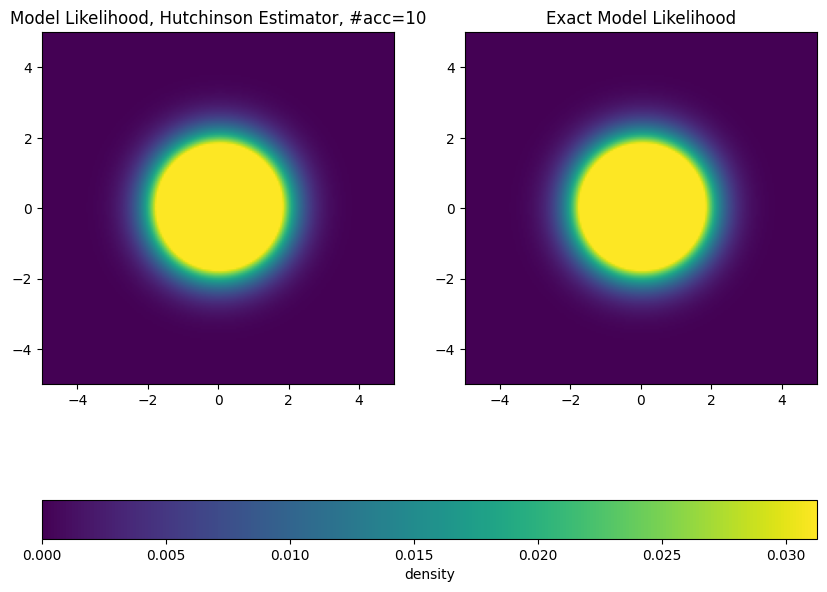

In [23]:
likelihood = torch.exp(log_p_acc).cpu().reshape(grid_size, grid_size).detach().numpy()
exact_likelihood = torch.exp(exact_log_p).cpu().reshape(grid_size, grid_size).detach().numpy()

fig, axs = plt.subplots(1, 2,figsize=(10,10))

cmin = 0.0
cmax = 1/32 # 1/32 is the gt likelihood value

norm = cm.colors.Normalize(vmax=cmax, vmin=cmin)

axs[0].imshow(likelihood, extent=(-5, 5, -5, 5), origin='lower', cmap='viridis', norm=norm)
axs[0].set_title('Model Likelihood, Hutchinson Estimator, #acc=%d' % num_acc)

axs[1].imshow(exact_likelihood, extent=(-5, 5, -5, 5), origin='lower', cmap='viridis', norm=norm)
axs[1].set_title('Exact Model Likelihood')

fig.colorbar(cm.ScalarMappable(norm=norm, cmap='viridis'), ax=axs, orientation='horizontal', label='density')
plt.show()